Student ID 25000148967

GitHub Repository Link https://github.com/robwhite-lis/Everything_Counts_Assessment_1

This is a Notebook about 2 of the UKs favourite topics, trains being late and the weather!

The dataset in question is available is the grandiosely named 

"Table 3138 - Train punctuality at recorded station stops by operator (periodic)"

and is available at https://dataportal.orr.gov.uk/statistics/performance/passenger-rail-performance/table-3138-train-punctuality-at-recorded-station-stops-by-operator-periodic/



In [145]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import io
import requests

df_url = 'https://raw.githubusercontent.com/robwhite-lis/Everything_Counts_Assessment_1/refs/heads/main/Train_punctuality.csv'
url_content = requests.get(df_url, verify = False).content
df_trains = pd.read_csv(io.StringIO(url_content.decode('utf-8')))

In [146]:
df_trains.describe()

,Number of recorded station stops,MAT Number of recorded station stops
count,3.940000e+03,3.940000e+03
mean,6.474878e+05,8.026629e+06
std,1.394560e+06,1.753747e+07
min,0.000000e+00,6.600000e+01
25%,5.639950e+04,6.938212e+05
50%,2.288885e+05,2.574194e+06
75%,5.195705e+05,6.623621e+06
max,7.012797e+06,8.441222e+07


Train arrivals are monitored in a fairly strange way across periods, which roughly equate to months, but not quite, as there are 13 of them in a year. (They are actually 28 days each). Also the year runs from April to March!

In [147]:
df_trains.head()

,Time Period,Operator,Number of recorded station stops,Early,On Time within 59 seconds,Time to 3,Time to 5,Time to 10,Time to 15,Time to 20,...,On time within 59 seconds MAA,Time to 3 MAA,Time to 5 MAA,Time to 10 MAA,Time to 15 MAA,Time to 20 MAA,Time to 30 MAA,15 minutes plus MAA,20 minutes plus MAA,30 minutes plus MAA
0,Apr 2014 to Mar 2015 (Period 01),Great Britain,4736697,35.64,68.70,88.43,94.38,98.23,99.17,99.55,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
1,Apr 2014 to Mar 2015 (Period 02),Great Britain,5061146,35.05,67.70,87.50,93.69,97.91,98.98,99.42,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
2,Apr 2014 to Mar 2015 (Period 03),Great Britain,5084203,35.00,67.67,87.43,93.65,97.89,98.99,99.45,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
3,Apr 2014 to Mar 2015 (Period 04),Great Britain,5123892,34.09,66.16,86.44,93.08,97.67,98.87,99.37,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
4,Apr 2014 to Mar 2015 (Period 05),Great Britain,5131680,32.78,63.95,84.38,91.54,97.03,98.56,99.20,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]


In [148]:
df_trains.dtypes

Time Period                             object
Operator                                object
Number of recorded station stops         int64
Early                                   object
On Time within 59 seconds               object
Time to 3                               object
Time to 5                               object
Time to 10                              object
Time to 15                              object
Time to 20                              object
Time to 30                              object
15 minutes plus                         object
20 minutes plus                         object
30 minutes plus                         object
MAT Number of recorded station stops     int64
Early MAA                               object
On time within 59 seconds MAA           object
Time to 3 MAA                           object
Time to 5 MAA                           object
Time to 10 MAA                          object
Time to 15 MAA                          object
Time to 20 MA

OK so let's clean up the date period into something more useable

In [149]:
# Here we are using a regular expression which can be created online
df_trains[["Start_Year", "Period"]] = df_trains["Time Period"].str.extract(r'(\d{4}).*Period (\d{2})')

In [150]:
df_trains["Start_Year"] = df_trains["Start_Year"].astype(int)
df_trains["Period"] = df_trains["Period"].astype(int)

In [151]:
df_trains[["Time Period", "Start_Year", "Period"]]

,Time Period,Start_Year,Period
0,Apr 2014 to Mar 2015 (Period 01),2014,1
1,Apr 2014 to Mar 2015 (Period 02),2014,2
2,Apr 2014 to Mar 2015 (Period 03),2014,3
3,Apr 2014 to Mar 2015 (Period 04),2014,4
4,Apr 2014 to Mar 2015 (Period 05),2014,5
...,...,...,...
3935,Apr 2025 to Mar 2026 (Period 03),2025,3
3936,Apr 2025 to Mar 2026 (Period 04),2025,4
3937,Apr 2025 to Mar 2026 (Period 05),2025,5
3938,Apr 2025 to Mar 2026 (Period 06),2025,6


Now let's add a Season column

Bearing in mind that the periods run April to March, and there are 13 of them, I've made the following assingments which roughly translate as

Period 1 - 3 spring (April, May, June)

Period 4 - 6 Summe (July, August, September
r
Period 7 - 9 Aumntu (October, November, Decembe
mn
Period 10 - 13  terWin (January, February, March and a bit of Aprter


In [152]:
bins = [0,3,6,9,13]
labels = ["Spring", "Summer", "Autumn", "Winter"]
df_trains["Season"] = pd.cut(df_trains["Period"], bins=bins, labels=labels)

Train arrivals are monitored in a fairly strange way across periods, which roughly equate to months, but not quite, as there are 13 of them in a year. (They are actually 28 days each). Also the year runs from April to March!

OK so let's clean up the date period into something more useable

Now clean the data into just the fields we need for this analysis.

We'll look at that "On Time", +3 mins, +5 mins and + 10 mins

First let's check the column names

In [153]:
df_trains.columns

Index(['Time Period', 'Operator', 'Number of recorded station stops', 'Early',
       'On Time within 59 seconds', 'Time to 3', 'Time to 5', 'Time to 10',
       'Time to 15', 'Time to 20', 'Time to 30', '15 minutes plus',
       '20 minutes plus', '30 minutes plus',
       'MAT Number of recorded station stops', 'Early MAA',
       'On time within 59 seconds MAA', 'Time to 3 MAA', 'Time to 5 MAA',
       'Time to 10 MAA', 'Time to 15 MAA', 'Time to 20 MAA', 'Time to 30 MAA',
       '15 minutes plus MAA', '20 minutes plus MAA', '30 minutes plus MAA',
       'Start_Year', 'Period', 'Season'],
      dtype='object')

In [154]:
df_trains_clean = df_trains[['Start_Year', 'Period', 'Season', 'Operator', 'Number of recorded station stops', 'Early',
       'On Time within 59 seconds', 'Time to 3', 'Time to 5', 'Time to 10',
       'Time to 15', 'Time to 20', 'Time to 30' ]].copy()

In [155]:
numeric_cols = [
    'Start_Year', 'Period', 'Number of recorded station stops', 'Early',
    'On Time within 59 seconds', 'Time to 3', 'Time to 5', 'Time to 10',
    'Time to 15', 'Time to 20', 'Time to 30'
]

df_trains_clean[numeric_cols] = df_trains_clean[numeric_cols].apply(
    pd.to_numeric, errors='coerce'
)

In [156]:
df_trains_clean.columns

Index(['Start_Year', 'Period', 'Season', 'Operator',
       'Number of recorded station stops', 'Early',
       'On Time within 59 seconds', 'Time to 3', 'Time to 5', 'Time to 10',
       'Time to 15', 'Time to 20', 'Time to 30'],
      dtype='object')

In [157]:
df_trains_clean.dtypes

Start_Year                             int64
Period                                 int64
Season                              category
Operator                              object
Number of recorded station stops       int64
Early                                float64
On Time within 59 seconds            float64
Time to 3                            float64
Time to 5                            float64
Time to 10                           float64
Time to 15                           float64
Time to 20                           float64
Time to 30                           float64
dtype: object

In [158]:
df_trains_clean

,Start_Year,Period,Season,Operator,Number of recorded station stops,Early,On Time within 59 seconds,Time to 3,Time to 5,Time to 10,Time to 15,Time to 20,Time to 30
0,2014,1,Spring,Great Britain,4736697,35.64,68.70,88.43,94.38,98.23,99.17,99.55,99.83
1,2014,2,Spring,Great Britain,5061146,35.05,67.70,87.50,93.69,97.91,98.98,99.42,99.77
2,2014,3,Spring,Great Britain,5084203,35.00,67.67,87.43,93.65,97.89,98.99,99.45,99.79
3,2014,4,Summer,Great Britain,5123892,34.09,66.16,86.44,93.08,97.67,98.87,99.37,99.76
4,2014,5,Summer,Great Britain,5131680,32.78,63.95,84.38,91.54,97.03,98.56,99.20,99.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3935,2025,3,Spring,West Midlands Trains,350795,38.17,67.43,84.06,90.84,96.71,98.34,99.08,99.68
3936,2025,4,Summer,West Midlands Trains,347956,35.55,63.41,80.43,87.68,95.04,97.36,98.43,99.33
3937,2025,5,Summer,West Midlands Trains,345491,38.25,67.13,83.73,90.43,96.18,97.92,98.72,99.48
3938,2025,6,Summer,West Midlands Trains,358760,38.88,68.08,84.93,91.65,97.21,98.66,99.35,99.78


Finally we'll remove the "Great Britain" Operator as that is an aggregator.

We'll also remove 2025 data as it is incomplete.

In [159]:
df_trains_clean = df_trains_clean[df_trains_clean["Operator"] != "Great Britain"]

In [160]:
df_trains_clean = df_trains_clean[df_trains_clean["Start_Year"] != 2025]

In [161]:
df_trains_clean["Operator"].unique()

array(['England and Wales', 'Scotland', 'Avanti West Coast', 'c2c',
       'Caledonian Sleeper', 'Chiltern Railways', 'CrossCountry',
       'East Midlands Railway', 'Elizabeth line',
       'Govia Thameslink Railway', 'Grand Central',
       'Great Western Railway', 'Greater Anglia', 'Heathrow Express',
       'Hull Trains', 'London North Eastern Railway', 'London Overground',
       'Lumo', 'Merseyrail', 'Northern Trains', 'ScotRail',
       'South Western Railway', 'Southeastern', 'TfW Rail',
       'TransPennine Express', 'West Midlands Trains'], dtype=object)

In [162]:
df_trains_clean

,Start_Year,Period,Season,Operator,Number of recorded station stops,Early,On Time within 59 seconds,Time to 3,Time to 5,Time to 10,Time to 15,Time to 20,Time to 30
150,2014,1,Spring,England and Wales,4305016,36.06,68.58,88.07,94.11,98.12,99.11,99.52,99.81
151,2014,2,Spring,England and Wales,4600338,35.42,67.49,87.06,93.35,97.76,98.90,99.37,99.75
152,2014,3,Spring,England and Wales,4623174,35.38,67.56,87.10,93.40,97.77,98.93,99.41,99.78
153,2014,4,Summer,England and Wales,4664354,34.46,66.07,86.14,92.83,97.54,98.80,99.33,99.74
154,2014,5,Summer,England and Wales,4641560,33.79,65.01,85.04,91.91,97.07,98.53,99.17,99.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3928,2024,9,Autumn,West Midlands Trains,334650,27.02,53.65,73.50,83.08,93.36,96.72,98.15,99.27
3929,2024,10,Winter,West Midlands Trains,301583,34.17,62.82,80.59,88.55,95.99,98.27,99.18,99.78
3930,2024,11,Winter,West Midlands Trains,352979,38.57,68.11,84.92,91.62,97.08,98.58,99.23,99.74
3931,2024,12,Winter,West Midlands Trains,361197,39.34,69.59,86.55,92.61,97.23,98.59,99.22,99.68


Let's first look at some overall statistics which operators had the best "On time" record by year

We'll define year as the calendar year the data started in

In [163]:
df_trains_clean.sort_values(by=["Start_Year", "On Time within 59 seconds"], ascending=[True, False])

,Start_Year,Period,Season,Operator,Number of recorded station stops,Early,On Time within 59 seconds,Time to 3,Time to 5,Time to 10,Time to 15,Time to 20,Time to 30
612,2014,13,Winter,c2c,127182,57.15,88.90,97.80,98.87,99.52,99.81,99.94,99.99
602,2014,3,Spring,c2c,112651,52.90,87.84,97.52,98.91,99.63,99.78,99.92,99.99
605,2014,6,Summer,c2c,113319,54.68,87.64,96.57,97.97,99.02,99.33,99.45,99.73
610,2014,11,Winter,c2c,115587,54.84,87.27,96.91,98.45,99.51,99.83,99.95,99.99
601,2014,2,Spring,c2c,111373,52.96,87.17,97.20,98.80,99.66,99.79,99.89,99.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2024,9,Autumn,Hull Trains,2745,17.78,37.63,58.91,71.11,83.53,90.24,93.55,95.85
590,2024,11,Winter,Avanti West Coast,49745,18.17,36.62,55.33,65.39,78.48,85.29,89.73,94.84
1176,2024,9,Autumn,CrossCountry,74641,16.37,35.79,55.25,67.02,81.26,87.77,91.39,95.55
589,2024,10,Winter,Avanti West Coast,39656,16.33,33.61,51.42,61.39,74.59,82.63,88.07,94.46


In [164]:
df_trains_clean[df_trains_clean["Operator"].str.lower() == "c2c"]

,Start_Year,Period,Season,Operator,Number of recorded station stops,Early,On Time within 59 seconds,Time to 3,Time to 5,Time to 10,Time to 15,Time to 20,Time to 30
600,2014,1,Spring,c2c,102320,52.32,85.66,95.04,97.00,98.54,99.15,99.67,99.93
601,2014,2,Spring,c2c,111373,52.96,87.17,97.20,98.80,99.66,99.79,99.89,99.95
602,2014,3,Spring,c2c,112651,52.90,87.84,97.52,98.91,99.63,99.78,99.92,99.99
603,2014,4,Summer,c2c,116852,49.82,84.93,96.95,98.74,99.69,99.90,99.96,99.97
604,2014,5,Summer,c2c,116151,52.12,86.14,96.49,98.16,99.26,99.62,99.75,99.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,2024,9,Autumn,c2c,113216,43.98,76.42,93.10,97.26,99.37,99.85,99.94,99.98
739,2024,10,Winter,c2c,110383,49.52,79.88,93.14,96.65,98.84,99.46,99.77,99.94
740,2024,11,Winter,c2c,124314,46.57,77.59,91.71,95.58,98.17,99.00,99.34,99.75
741,2024,12,Winter,c2c,118801,47.36,79.51,93.93,97.30,99.06,99.41,99.61,99.79


In [165]:
(
 df_trains_clean.groupby(["Start_Year", "Operator"], as_index=False)
 .agg(sum_ontime=("On Time within 59 seconds", "sum"))
 .sort_values(["Start_Year", "sum_ontime"], ascending=[True, False])
)

,Start_Year,Operator,sum_ontime
24,2014,c2c,1122.87
11,2014,Heathrow Express,1047.86
2,2014,Chiltern Railways,979.65
15,2014,Merseyrail,926.62
19,2014,South Western Railway,912.52
...,...,...,...
265,2024,Hull Trains,660.84
276,2024,TransPennine Express,628.59
256,2024,CrossCountry,624.38
261,2024,Grand Central,592.09


Let's create a df for that now so we can plot easily

In [166]:
df_trains_year = (
 df_trains_clean.groupby(["Start_Year", "Operator"], as_index=False)
 .agg(sum_ontime=("On Time within 59 seconds", "sum"))
 .sort_values(["Start_Year", "sum_ontime"], ascending=[True, False])
)

In [167]:
df_trains_year.dtypes

Start_Year      int64
Operator       object
sum_ontime    float64
dtype: object

In [168]:
df_trains_year

,Start_Year,Operator,sum_ontime
24,2014,c2c,1122.87
11,2014,Heathrow Express,1047.86
2,2014,Chiltern Railways,979.65
15,2014,Merseyrail,926.62
19,2014,South Western Railway,912.52
...,...,...,...
265,2024,Hull Trains,660.84
276,2024,TransPennine Express,628.59
256,2024,CrossCountry,624.38
261,2024,Grand Central,592.09


Let's look at the top 5 train operators per year and create a table

In [169]:
df_top5 = (

    df_trains_year
        .sort_values(["Start_Year", "sum_ontime"], ascending=[True, False])
        .groupby("Start_Year")
        .head(5)
)
    

In [170]:
df_top5

,Start_Year,Operator,sum_ontime
24,2014,c2c,1122.87
11,2014,Heathrow Express,1047.86
2,2014,Chiltern Railways,979.65
15,2014,Merseyrail,926.62
19,2014,South Western Railway,912.52
49,2015,c2c,1097.80
36,2015,Heathrow Express,1045.09
30,2015,Elizabeth line,938.02
27,2015,Chiltern Railways,932.63
44,2015,South Western Railway,901.97


In [171]:
# Num periods = 13 - given we've simply added 13 percentages together we need to renormalize
num_periods = 13
# We'll store number of years as well as we'll need that later
num_years = 11

In [172]:
df_top5["sum_ontime"] = df_top5["sum_ontime"] / num_periods

In [173]:
# Let's rename the column so it makes more sense
df_top5 = df_top5.rename(columns={"sum_ontime": "% ontime"})

In [174]:
df_top5

,Start_Year,Operator,% ontime
24,2014,c2c,86.374615
11,2014,Heathrow Express,80.604615
2,2014,Chiltern Railways,75.357692
15,2014,Merseyrail,71.278462
19,2014,South Western Railway,70.193846
49,2015,c2c,84.446154
36,2015,Heathrow Express,80.391538
30,2015,Elizabeth line,72.155385
27,2015,Chiltern Railways,71.740769
44,2015,South Western Railway,69.382308


Now let's get the bottom 5

In [175]:
df_bottom5 = (

    df_trains_year
        .sort_values(["Start_Year", "sum_ontime"], ascending=[True, True])
        .groupby("Start_Year")
        .head(5)
)
    

In [176]:
# and do the same tidying up
df_bottom5["sum_ontime"] = df_bottom5["sum_ontime"] / num_periods
df_bottom5 = df_bottom5.rename(columns={"sum_ontime": "% ontime"})

In [177]:
df_bottom5

,Start_Year,Operator,% ontime
1,2014,Caledonian Sleeper,5.244615
22,2014,TransPennine Express,43.672308
0,2014,Avanti West Coast,46.590000
3,2014,CrossCountry,47.680769
13,2014,London North Eastern Railway,53.036923
47,2015,TransPennine Express,43.823846
25,2015,Avanti West Coast,48.616923
28,2015,CrossCountry,48.738462
37,2015,Hull Trains,50.688462
38,2015,London North Eastern Railway,51.016923


Let's take this idea a step further and plot the best and worst performers each year

In [178]:
best_per_year = (
    df_top5
    .sort_values(["Start_Year", "% ontime"], ascending=[True, False])
    .groupby("Start_Year")
    .head(1)
)

worst_per_year = (
    df_bottom5
    .sort_values(["Start_Year", "% ontime"], ascending=[True, True])
    .groupby("Start_Year")
    .head(1)
)


Now let's draw a graph

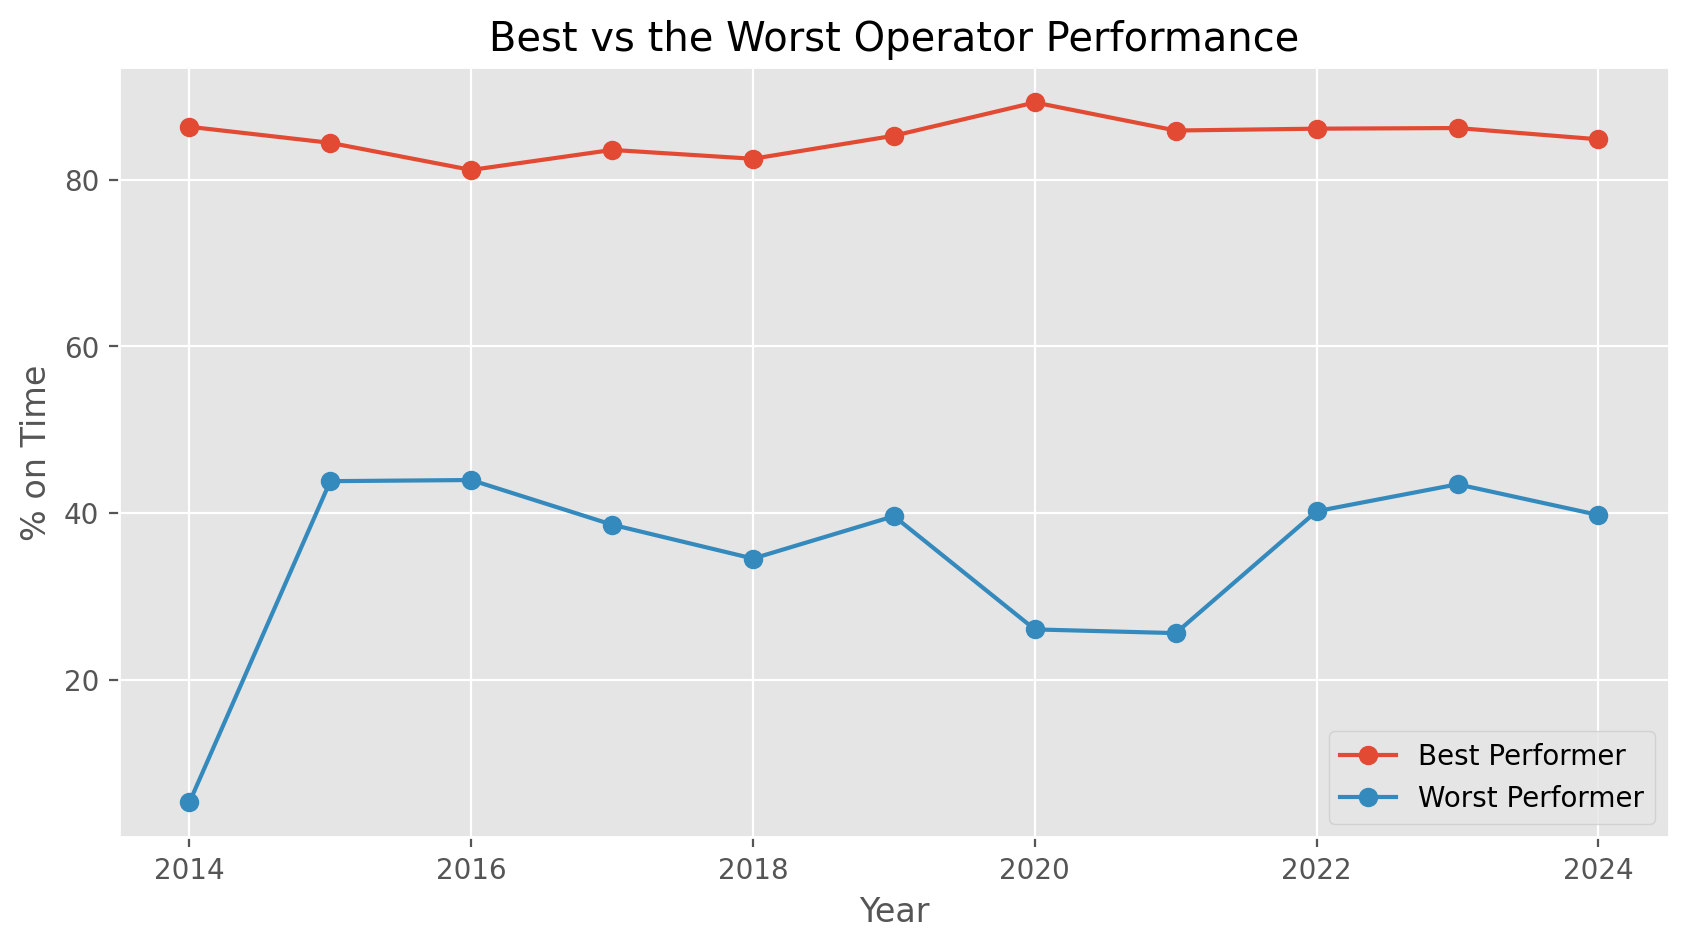

In [179]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,5)

# plt.hist(plot_data, bins = plot_data, edgecolor = 'black', linewidth = 1.2)

# Plot the best performer line
plt.plot(
    best_per_year["Start_Year"],
    best_per_year["% ontime"],
    marker="o",
    label="Best Performer"
)

# Plot the worst performer line
plt.plot(
    worst_per_year["Start_Year"],
    worst_per_year["% ontime"],
    marker="o",
    label="Worst Performer"
)



plt.xlabel("Year")
plt.ylabel("% on Time")
plt.title("Best vs the Worst Operator Performance")
plt.legend()

plt.show();

In [180]:
df_trains_season = (
 df_trains_clean.groupby(["Season", "Operator"], as_index=False)
 .agg(sum_ontime=("On Time within 59 seconds", "sum"))
 .sort_values(["Season", "sum_ontime"], ascending=[True, False])
)

# Now we need to normalize again. 
# Because of the 13 month "year" our Seasons are slightly uneven
# Winter has 44 records ( 4 periods) the other seasons have 33 ( 3 periods)
num_rows_winter = 44
num_rows = 33

# We can use a vector opreration 
df_trains_season["sum_ontime"] = np.where(
    df_trains_season["Season"] == "Winter",
    df_trains_season["sum_ontime"] / num_rows_winter,   # IF Winter
    df_trains_season["sum_ontime"] / num_rows            # ELSE all other seasons
)

df_trains_season = df_trains_season.rename(columns={"sum_ontime": "% ontime"})

In [181]:
df_trains_season[df_trains_season["Operator"] == "c2c"]

,Season,Operator,% ontime
25,Spring,c2c,84.505152
51,Summer,c2c,82.238182
77,Autumn,c2c,79.279394
103,Winter,c2c,83.291364


In [182]:
df_trains_season.columns

Index(['Season', 'Operator', '% ontime'], dtype='object')

In [183]:

# Mean on-time by season (overall)
season_summary = df_trains_season.groupby("Season")["% ontime"].agg(['mean'])
print(season_summary.sort_values("mean"))

# Worst season for each operator
# idxmin is a function I searched for, it returns the index of the row with the minimum value for in 
# this case a given Operator
worst_per_operator = (
    df_trains_season
    .loc[df_trains_season.groupby("Operator")["% ontime"].idxmin()]
    [["Operator", "Season", "% ontime"]]
)
print(worst_per_operator)

# Count frequency of each worst season
common_worst = worst_per_operator["Season"].value_counts()
print(common_worst)



             mean
Season           
Autumn  57.349172
Winter  62.858584
Summer  63.229207
Spring  65.863462
                        Operator  Season   % ontime
52             Avanti West Coast  Autumn  42.476667
53            Caledonian Sleeper  Autumn  54.856364
54             Chiltern Railways  Autumn  68.604545
55                  CrossCountry  Autumn  43.505758
56         East Midlands Railway  Autumn  52.776364
57                Elizabeth line  Autumn  74.115455
58             England and Wales  Autumn  61.463030
59      Govia Thameslink Railway  Autumn  62.122121
60                 Grand Central  Autumn  47.424242
61         Great Western Railway  Autumn  58.713030
62                Greater Anglia  Autumn  69.528182
63              Heathrow Express  Autumn  78.051212
64                   Hull Trains  Autumn  42.866061
65  London North Eastern Railway  Autumn  48.951515
66             London Overground  Autumn  68.999394
41                          Lumo  Summer  16.006364
68      

So from the above, Autumn is clearly the least reliable season. In our definition that is approx. October, November & December